In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
LIKERT_SCALE_TO_TEXT = {1: 'Strongly disagree', 2: 'Somewhat disagree', 3: 'Neither agree nor disagree',
                        4: 'Somewhat agree', 5: 'Strongly agree'}
LIKERT_SCALE_TO_NUM = {'Strongly disagree': 1, 'Somewhat disagree': 2, 'Neither agree nor disagree': 3,
                       'Somewhat agree': 4, 'Strongly agree': 5}
likert_type = pd.CategoricalDtype(categories=LIKERT_SCALE_TO_NUM.keys(), ordered=True)

In [3]:
def read_qualtrics_csv(csv_path):
    df = pd.read_csv(csv_path, index_col='Random ID', skiprows=[1, 2])
    _df_ = pd.read_csv(csv_path, index_col='Random ID', nrows=1)
    column_names = []
    pre_hoc_cols = []
    for col_name, col_string in zip(df.columns.to_list(), _df_[df.columns].iloc[0].to_list()):
        if 'personal' in col_name:
            _new_name = f"{col_name.split('-', 1)[0].strip()}-{col_string.rsplit('-', 1)[1].strip()}".strip()
            column_names.append(_new_name)
            pre_hoc_cols.append(_new_name)
        else:
            column_names.append(col_name)
    df.columns = column_names
    df.columns = df.columns.str.replace('&nbsp', '')
    return df, pre_hoc_cols


def pivot_likert_df(df, pre_hoc_cols):
    _df = df.loc[:, df.columns.isin(pre_hoc_cols)]
    _df.columns = pd.MultiIndex.from_tuples(tuple(_df.columns.str.split('-')), names=['topic', 'statement'])
    ratings_long_df = _df.melt(ignore_index=False, value_name='rate').fillna(0)
    # ratings_long_df = ratings_long_df.merge(df[['wid', 'batch', 'duration', 'EndDate']], left_index=True,
    #                                         right_index=True)
    # topic_mean_rate = ratings_long_df.groupby(['topic'])['rate'].mean()
    # ratings_long_df = ratings_long_df.assign(topic_mean=ratings_long_df['topic'].map(topic_mean_rate))
    ratings_long_df.index.set_names('rid', inplace=True)
    return ratings_long_df


results = []
_total_len = 0
for task in ['Rating', 'Ranking']:
    for color in ['Red', 'Blue', 'Green']:
        df, pre_hoc_cols = read_qualtrics_csv(f'data/Qualtrics/{task}{color}.csv')
        df_len = len(df)
        _total_len += df_len
        print(f'{task}{color}: {df_len} rows')
        # print(df.head(3))
        results.append(pivot_likert_df(df, pre_hoc_cols))
        # df.to_csv(f'data/Qualtrics/{task}{color}.csv')
        print(f'{task}{color} done')
print(f'Total: {_total_len} rows')
pre_hoc_df = pd.concat(results)

comb_df_file = 'data/comb_df.parquet.zstd'

accepted_rids = pd.read_parquet(comb_df_file)['rid'].astype(int).unique()

pre_hoc_df = pre_hoc_df.loc[accepted_rids]
pre_hoc_df = pre_hoc_df.assign(agreement_text=pre_hoc_df['rate'].map(LIKERT_SCALE_TO_TEXT).astype(likert_type))
pre_hoc_df.to_csv('data/pre_hoc.csv')
pre_hoc_df

RatingRed: 112 rows
RatingRed done
RatingBlue: 119 rows
RatingBlue done
RatingGreen: 116 rows
RatingGreen done
RankingRed: 110 rows
RankingRed done
RankingBlue: 113 rows
RankingBlue done
RankingGreen: 107 rows
RankingGreen done
Total: 677 rows


,topic,statement,rate,agreement_text
rid,,,,
12404386894,213,I am familiar with this topic,4.0,Somewhat agree
12404386894,213,This topic is interesting to me,3.0,Neither agree nor disagree
12404386894,213,It should be easy to find relevant information...,4.0,Somewhat agree
12404386894,253,I am familiar with this topic,5.0,Strongly agree
12404386894,253,This topic is interesting to me,2.0,Somewhat disagree
...,...,...,...,...
976386207551,244,This topic is interesting to me,4.0,Somewhat agree
976386207551,244,It should be easy to find relevant information...,5.0,Strongly agree
976386207551,238,I am familiar with this topic,5.0,Strongly agree


In [4]:
plt.rcParams.update(plt.rcParamsDefault)

thesis_fmt = {
    "ps.useafm": True,
    # "ps.usedistiller": "xpdf",
    "font.family": "serif",
    "font.serif": ['garamond', 'urw-garamond', 'Garamond 3 URW'],
    # "text.latex.preamble": r"\usepackage{mathdesign}",
    "text.latex.preamble": r"\usepackage{microtype}"
                           r"\usepackage{lmodern}"
                           r"\usepackage[scaled]{beramono}"
                           r"\usepackage[urw-garamond, uppercase=upright]{mathdesign}"
                           r"\usepackage{garamondx}"
                           r"\renewcommand{\ttdefault}{lmtt}"
                           r"\usepackage{pifont}"
                           r"\usepackage{setspace}"
                           r"\linespread{1.05}"
                           r"\DeclareMathAlphabet{\xcal}{OMS}{cmsy}{m}{n}",
    # "mathtext.default": 'it',
    # "mathtext.fontset": 'custom',
    # "mathtext.rm": 'Garamond 3 URW Italic',
    # "mathtext.it": 'Garamond 3 URW Italic',
    'text.usetex': True,
    # "font.sans-serif": "Linux Biolinum",
    'font.size': 12,
    # 'pdf.fonttype': 42,
    #     'figure.facecolor': (0.98, 0.98, 0.98),
    #     'figure.facecolor':'#212121',
    #     'text.color': '#23373b',
    #     'axes.labelcolor': 'white',
    #     'xtick.color': 'white',
    #     'ytick.color': 'white',
    #     'axes.titlecolor':'white',
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (10, 5),
    'legend.borderaxespad': 0.5,
    'legend.fontsize': 'small',
    'legend.title_fontsize': 'small',
    #     'legend.facecolor':'white',
    #     "axes.labelpad": 20.0
    "axes.labelpad": 5.0,
    # 'axes.titlesize':38,
    #     'axes.labelsize':'medium'
}

plt.rcParams.update(thesis_fmt)

In [5]:
import numpy as np

np.sort(pre_hoc_df['topic'].unique())

array(['213', '223', '234', '238', '244', '253', '259', '261', '266',
       '283', '286', '297'], dtype=object)

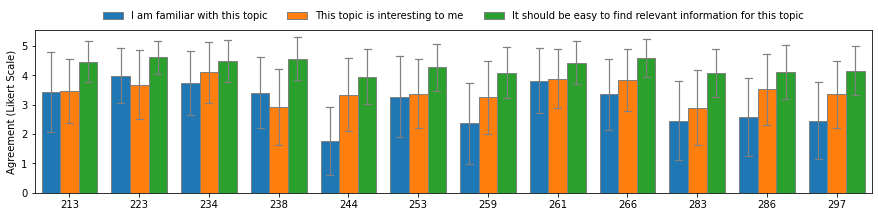

In [6]:
plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams.update(thesis_fmt)

# topics_order = pre_hoc_df.groupby(['topic'])['rate'].mean().sort_values().index.get_level_values(0).unique()
topics_order = np.sort(pre_hoc_df['topic'].unique())

plt.close()
plt.figure(figsize=(15, 3))
ax = sns.barplot(x='topic', y='rate', hue='statement', data=pre_hoc_df, errorbar='sd', capsize=.1, errcolor=".5",
                 errwidth=1.2,
                 linewidth=1, edgecolor=".5", saturation=1, width=0.8, order=topics_order)
plt.ylabel('Agreement (Likert Scale)')
plt.xlabel(None)

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=3, frameon=False, title=None)
# sns.move_legend(ax, "best", bbox_to_anchor=(1, 1), ncol=1, frameon=True)
plt.show()

In [7]:
df = pre_hoc_df.groupby(['topic', 'statement'])['agreement_text'].value_counts(normalize=True).unstack().sort_index(
    ascending=False) * 100
# select only certain statement index level 2
familiar_index = df.index.get_level_values('statement').isin(['I am familiar with this topic'])
interesting_index = df.index.get_level_values('statement').isin(['This topic is interesting to me'])
easy_index = df.index.get_level_values('statement').isin(
    ['It should be easy to find relevant information for this topic'])
familiar_df = df.loc[familiar_index].reset_index('statement', drop=True)
interesting_df = df.loc[interesting_index].reset_index('statement', drop=True)
easy_df = df.loc[easy_index].reset_index('statement', drop=True)

In [27]:
def plot_likert_df(df, title='Likert Scale', filename='plots/likert_scale.pdf', topics_order=None):
    if topics_order is not None:
        df = df.loc[topics_order]
    ax = df.plot(kind='barh', stacked=True, mark_right=True, figsize=(10, 4), color=sns.color_palette("coolwarm", 5),
                 edgecolor='black', linewidth=0.5, title=title)
    plt.ylabel(None)
    sns.despine(ax=ax, left=False, bottom=False)

    for col in df:
        for i, (cs, ab, pc) in enumerate(zip(df.cumsum(1)[col], df[col], df[col])):
            if pc > 3.7:
                plt.text(cs - ab / 2, i, f'{pc:.0f}' + r'\%', va='center', ha='center', fontsize='small')
            if 3.2 < pc <= 3.7:
                plt.text(cs - ab / 2, i, f'{pc:.0f}' + r'\%', va='center', ha='center', fontsize='small')
            if 2.4 < pc <= 3.2:
                plt.text(cs - ab / 2, i, f'{pc:.0f}' + r'\%', va='center', ha='center', fontsize='x-small')
            if 2 < pc <= 2.4:
                plt.text(cs - ab / 2, i, f'{pc:.0f}' + r'\%', va='center', ha='center', fontsize='xx-small',
                         weight='ultralight')
    # sns.move_legend(ax, "upper center", bbox_to_anchor=(0.49, -0.05), ncol=5, frameon=False, title=None)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.48, 1), ncol=5, frameon=False, title=None)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

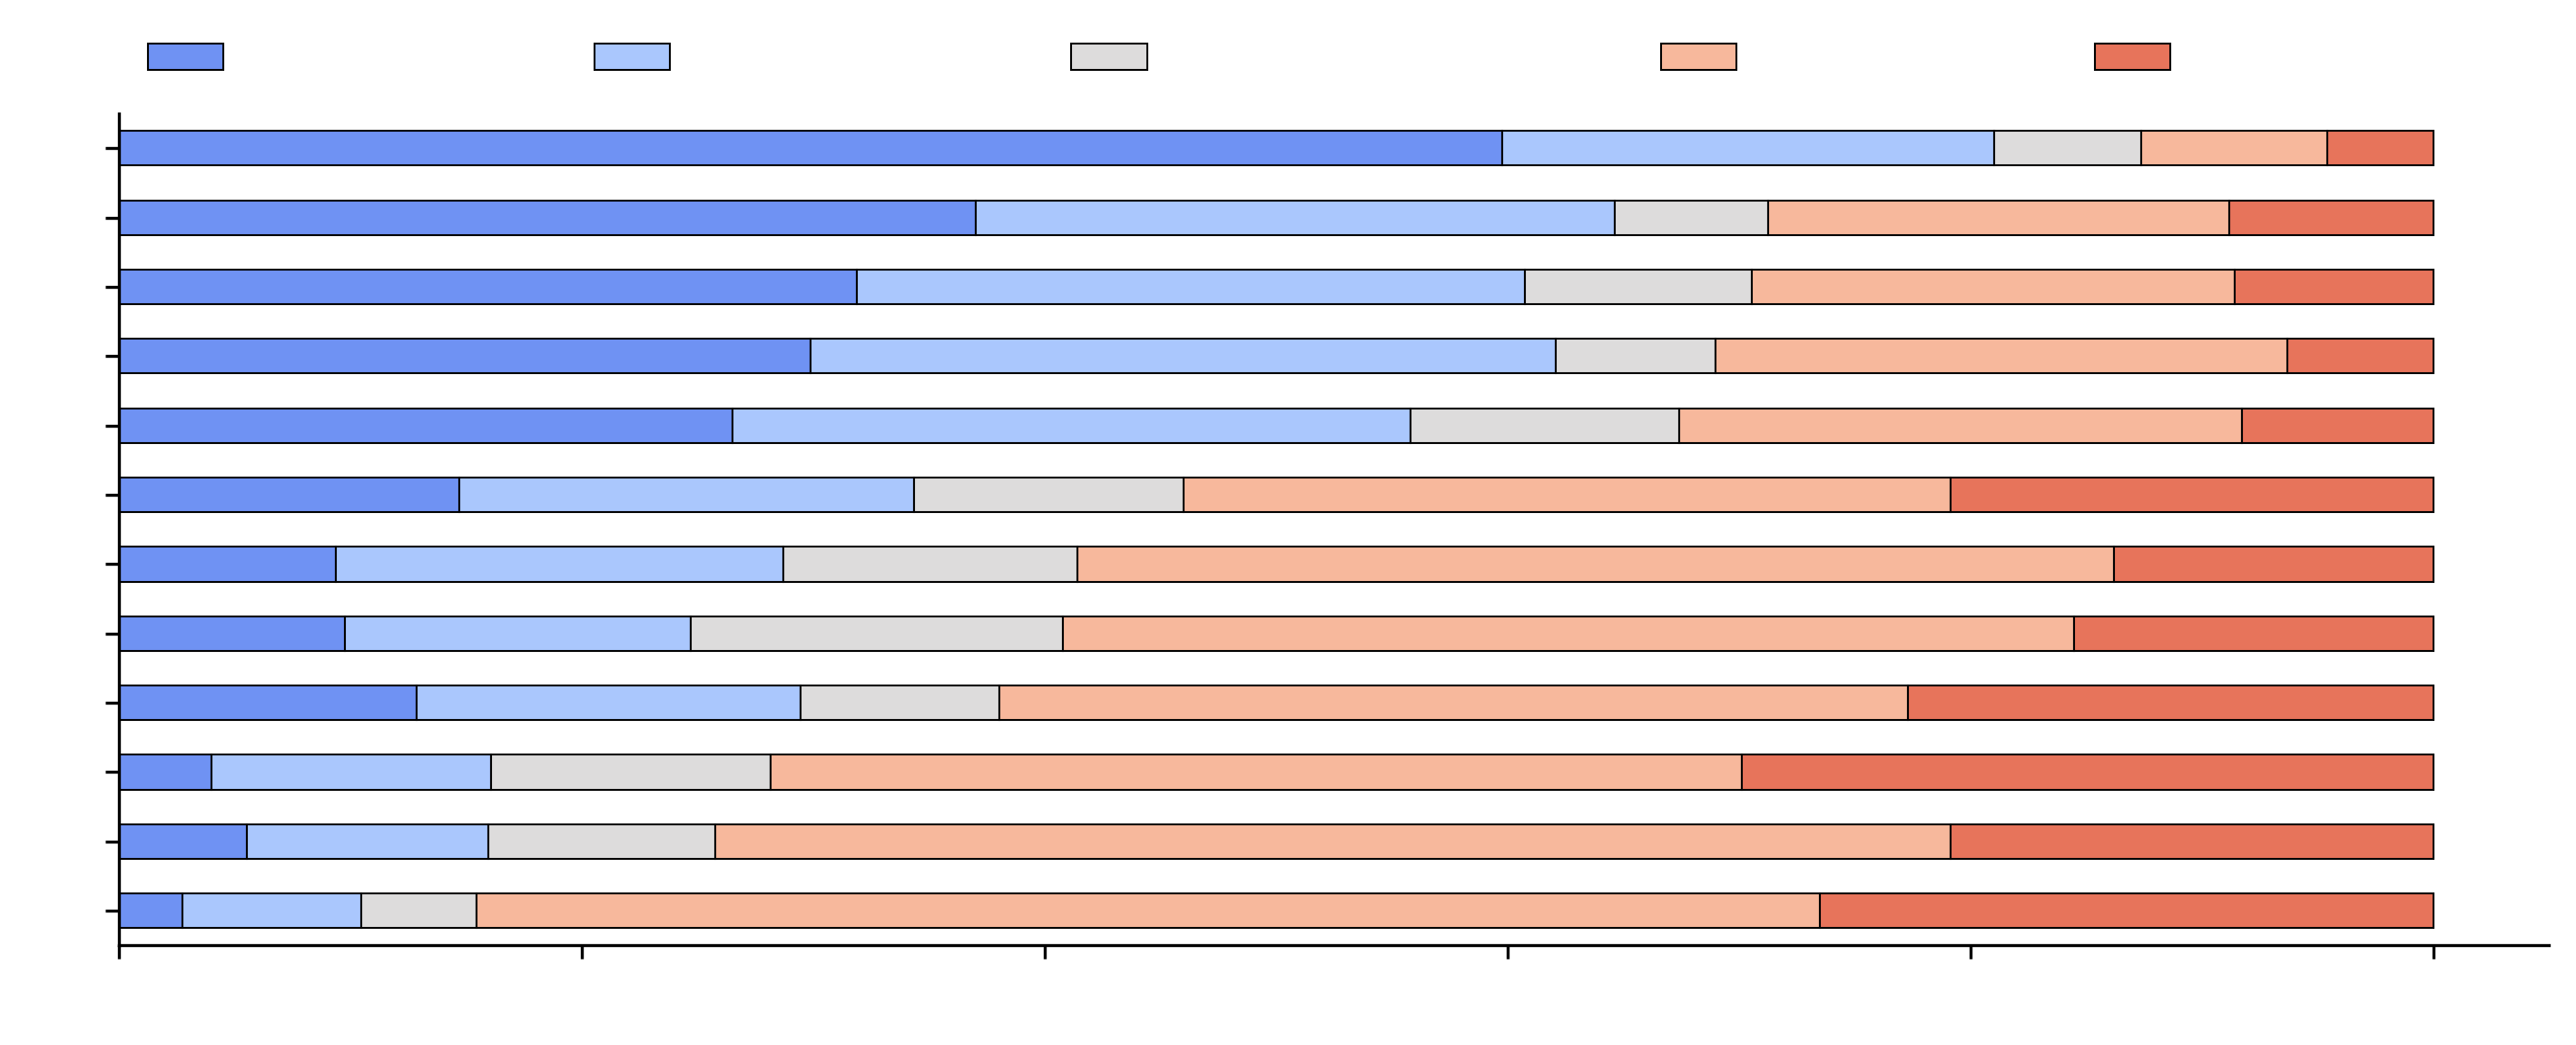

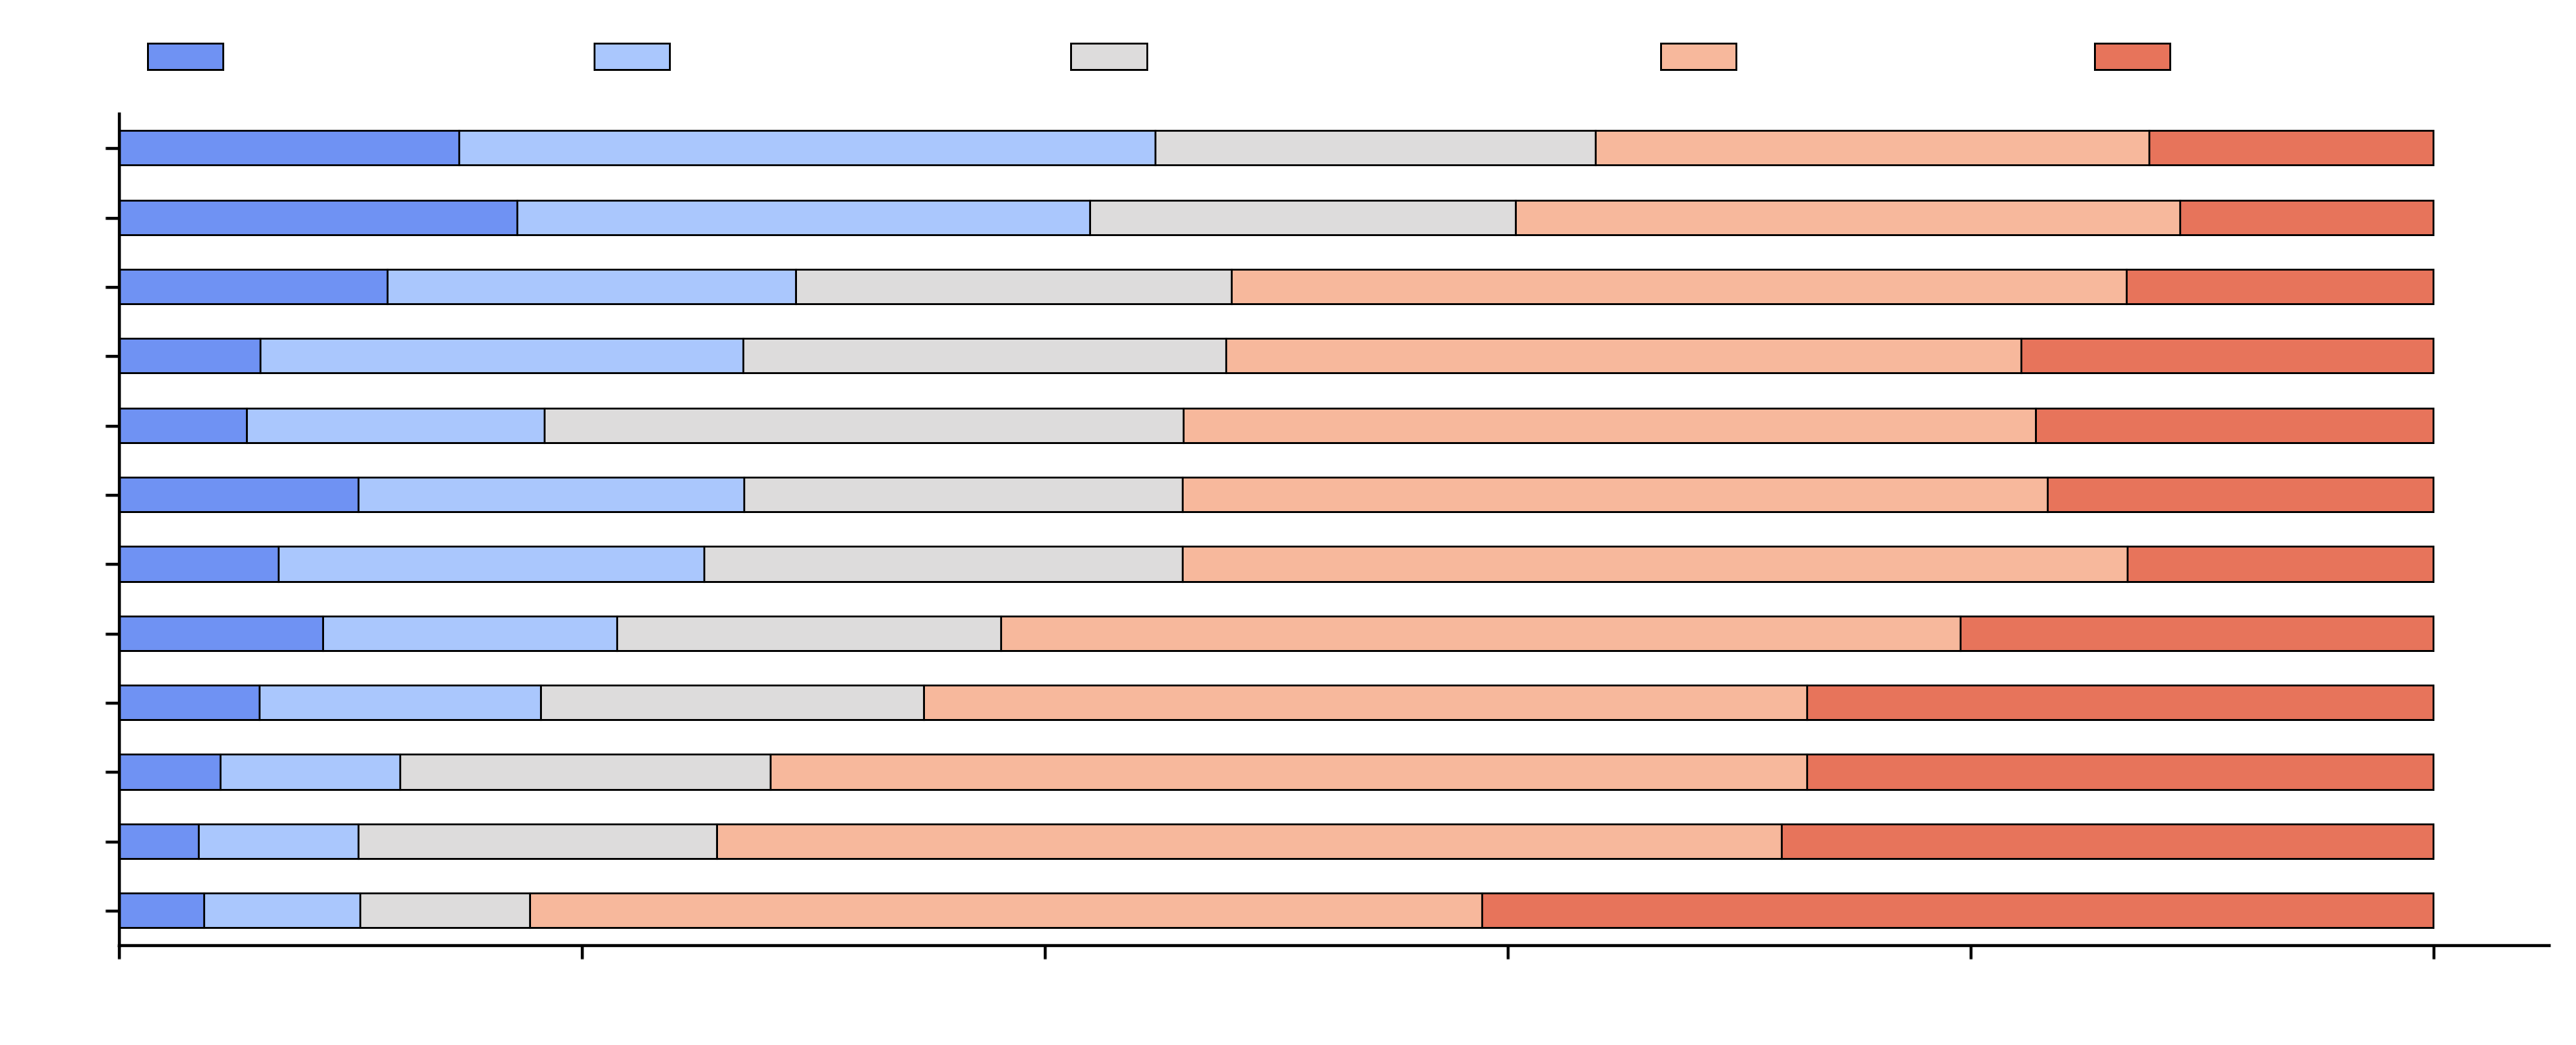

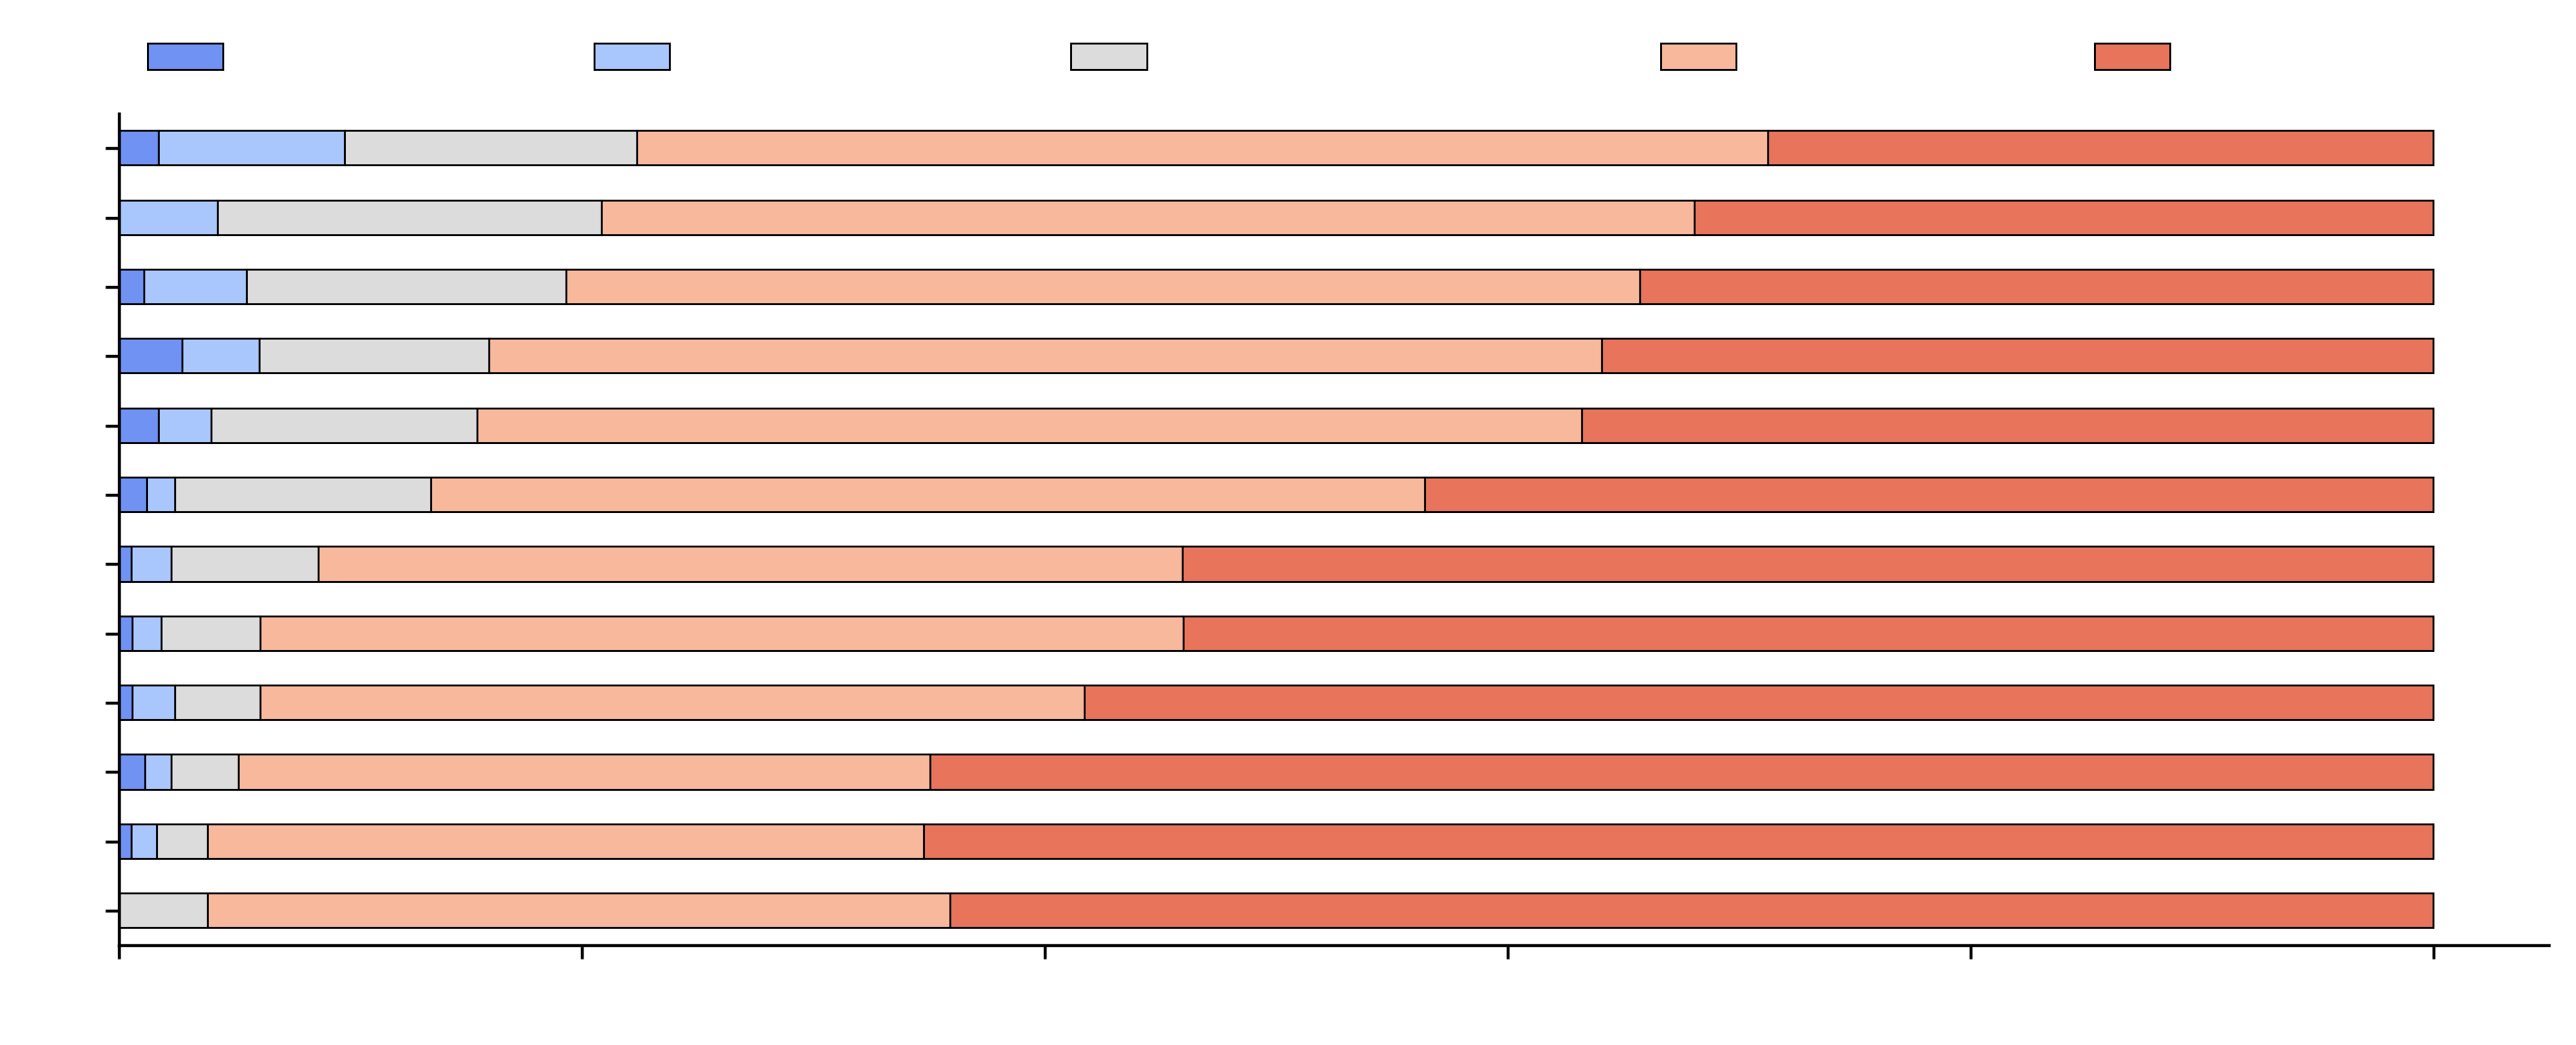

In [45]:
# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(thesis_fmt)

fam_topics_order = familiar_df[['Somewhat agree', 'Strongly agree']].sum(axis=1).sort_values(ascending=False).index
int_topics_order = interesting_df[['Somewhat agree', 'Strongly agree']].sum(axis=1).sort_values(ascending=False).index
easy_topics_order = easy_df[['Somewhat agree', 'Strongly agree']].sum(axis=1).sort_values(ascending=False).index

plot_likert_df(familiar_df, title=None, topics_order=fam_topics_order, filename='plots/familiar_likert.pdf')
plot_likert_df(interesting_df, title=None, topics_order=int_topics_order, filename='plots/interesting_likert.pdf')
plot_likert_df(easy_df, title=None, topics_order=easy_topics_order, filename='plots/easy_likert.pdf')
# plot_likert_df(familiar_df.sort_values('Strongly disagree', ascending=False),
#                title='\emph{I am familiar with this topic}', filename='plots/familiar_likert.pdf')
# plot_likert_df(interesting_df.sort_values('Strongly disagree', ascending=False), title="``This topic is interesting to me''", filename='plots/interesting_likert.pdf')
# plot_likert_df(easy_df.sort_values('Strongly agree', ascending=True),
#                title='It should be easy to find relevant information for this topic', filename='plots/easy_likert.pdf')


In [38]:
familiar_df[['Somewhat disagree', 'Strongly disagree']].sum(axis=1).sort_values()

topic
223    10.497238
234    15.950920
261    16.091954
238    24.712644
266    28.729282
213    29.447853
253    34.355828
286    55.801105
283    60.736196
297    62.068966
259    64.640884
244    81.034483
dtype: float64